In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import itertools
from tqdm import tqdm_notebook

In [446]:
def read_tsv(folder, model, filename, rename=None, ext='tsv'):
    filename = '' if not filename else f'_{filename}'
    res = pd.read_csv(f'{folder}/{model}{filename}.{ext}', header=None, delimiter='\t')
    if rename:
        res = res.rename({0: rename}, axis=1)
    return res

def process_file(folder, model, filename, **kwargs):
    map_acts = kwargs.pop('map_acts', False)
    df = read_tsv(folder, model, filename, **kwargs)
    
    if map_acts:
        df = df.applymap(lambda arr: np.array([float(x) for x in arr[1:-1].split(', ')]))
        
    return np.array(df.values.tolist())

def get_files(model='binary_finetune', folder='experiments/may12_3', map_acts=False):
    neg_act = process_file(folder, model, 'neg_layer_activation', map_acts=map_acts)
    pos_act = process_file(folder, model, 'pos_layer_activation', map_acts=map_acts)
    output_logits = process_file(folder, model, '', map_acts=True)
    return neg_act, pos_act, output_logits

def hist_dist(hists):
    vals = [(hist[1][1:] + hist[1][:-1]) / 2 for hist in hists]
    weights = [hist[0] for hist in hists]
    return scipy.stats.wasserstein_distance(vals[0], vals[1], weights[0], weights[1])


def get_groups(pos_output_logits, neg_output_logits, pos_act, neg_act, dim):
    positive = pos_output_logits[:, dim]
    negative = neg_output_logits[:, dim]

    pos_entail = pos_act[positive[:, 0] < positive[:, 1]][..., dim - 1]
    neg_entail = neg_act[negative[:, 0] < negative[:, 1]][..., dim - 1]
    pos_contradict = pos_act[positive[:, 0] > positive[:, 1]][..., dim - 1]
    neg_contradict = neg_act[negative[:, 0] > negative[:, 1]][..., dim - 1]

    groups = [pos_entail, neg_entail, pos_contradict, neg_contradict]

    return groups

def norm_acts(pos, neg):
    acts = np.vstack((pos, neg))
    amax, amin = acts.max(axis=0), acts.min(axis=0)
    print(acts.min(axis=0).shape)
    return [2 * (act - amin) / (amax - amin) - 1 for act in [pos, neg]]
    return [act / np.max(act, axis=0) for act in [pos, neg]]
    return pos / act_norm, neg / act_norm

def relevant_dims(files):
    neg_act, pos_act, output_logits = files
    pos_output_logits = output_logits[:, ::2]
    neg_output_logits = output_logits[:, 1::2]
    
    pos_act, neg_act = norm_acts(pos_act, neg_act)
    
    batch_size, hidden_dims, _ = pos_output_logits.shape
    count = 0
    dist_dims = []
    for dim in tqdm_notebook(range(1, hidden_dims)):
        groups = get_groups(pos_output_logits, neg_output_logits, pos_act, neg_act, dim)
        
        # TODO: change means/medians and plotting condition to cos dist
        means = np.array([np.mean(g) for g in groups])
        medians = np.array([np.median(g) for g in groups])
        hists = [np.histogram(g, bins=16) for g in groups]
        pos_hists = [hists[0], hists[2]]
        neg_hists = [hists[1], hists[3]]
        
        dist = np.sum([hist_dist(x) for x  in itertools.product(pos_hists, neg_hists)])
        dist -= (hist_dist(pos_hists) + hist_dist(neg_hists))
        
        diffs = np.subtract.outer(means[[1, 3]], means[[0, 2]])
        diffs_2 = np.subtract.outer(medians[[1, 3]], medians[[0, 2]])
        
        dist_dims.append((dist, dim))
        
    dist_dims.sort()
    return dist_dims

def plot_dims(dist_dims, files, k=5, save_name=None):
    neg_act, pos_act, output_logits = files
    pos_output_logits = output_logits[:, ::2]
    neg_output_logits = output_logits[:, 1::2]
    
    pos_act, neg_act = norm_acts(pos_act, neg_act)
    
    labels = ['+ entailment', '- entailment', '+ contradiction', '- contradiction']
    
    fig, axes = plt.subplots(1, k, figsize=(12, 3), sharey=True)
    
    for i, (dist, dim) in enumerate(dist_dims[-k:]):
        groups = get_groups(pos_output_logits, neg_output_logits, pos_act, neg_act, dim)

        print(dim, dist)
        sns.set_palette("husl")
        for g, l in zip(groups, labels):
            sns.distplot(g, hist=True, kde=True, 
                         bins=int(80/5), label=l,
                         hist_kws={'edgecolor':'black'},
                         kde_kws={'linewidth': 4},
                         ax=axes[i])
        axes[i].set_title(f'Dimension {dim}')
        
    axes[1].set_xlabel('Normalized Neuron Activation')
    axes[0].set_ylabel('Sample Count')
        
            
    handles, labels = axes[-1].get_legend_handles_labels()
    
    plt.subplots_adjust(bottom=0.8, top=1)
    lgd = plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, ncol=1, borderaxespad=0)
    fig.tight_layout(pad=0.25)
    if save_name:
        plt.savefig(save_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [454]:
files = get_files(model='three_way_finetune', folder='experiments/may12_1')

In [455]:
dd = relevant_dims(files)

(768,)


(768,)
66 1.063533704185042
421 1.0652038666774812
352 1.0880670850049237


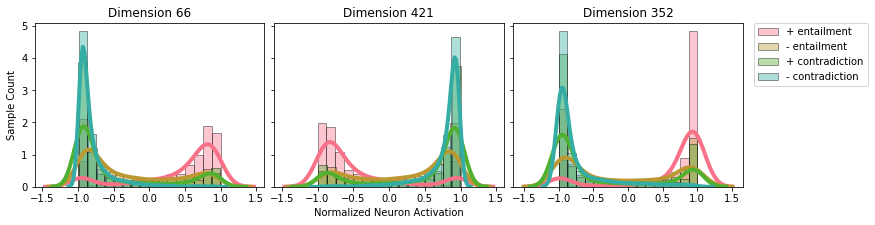

In [456]:
plot_dims(dd, files, k=3, save_name='three_1')

In [27]:
sns.color_palette("husl")

6

In [262]:
pol[np.stack((pol[..., 0] < pol[..., 1],) * 2, axis=2)].shape

(13842,)

In [222]:
o

array([[[[0.30011466, 0.69988531, 1.        ],
         [0.3109813 , 0.68901867, 1.        ],
         [0.31129771, 0.68870229, 1.        ],
         ...,
         [0.31085467, 0.68914527, 1.        ],
         [0.3110294 , 0.68897057, 1.        ],
         [0.31105271, 0.68894726, 1.        ]],

        [[0.30583954, 0.69416046, 1.        ],
         [0.30392027, 0.69607967, 1.        ],
         [0.30387118, 0.69612879, 1.        ],
         ...,
         [0.30363822, 0.69636178, 1.        ],
         [0.30381912, 0.69618088, 1.        ],
         [0.30380425, 0.69619572, 1.        ]],

        [[0.29487121, 0.70512873, 1.        ],
         [0.29513368, 0.70486635, 1.        ],
         [0.29514304, 0.70485693, 1.        ],
         ...,
         [0.2947287 , 0.70527136, 1.        ],
         [0.29509953, 0.7049005 , 1.        ],
         [0.29509586, 0.70490414, 1.        ]],

        ...,

        [[0.29460022, 0.70539981, 1.        ],
         [0.29431516, 0.70568478, 1.        ]